# 5. Descomposición de datos y técnicas de análisis
## 5.3. Análisis de clúster

El objetivo del análisis de clúster es encontrar subgrupos o clústers en un conjunto de datos. Al agrupar las observaciones, buscamos una *partición* tal que las observaciones *dentro* de cada grupo sean lo màs similares entre sí que entre grupos diferentes.

El análisis de clúster también es usado como una forma de estadística descriptiva para asegurarse de que los datos realmente consisten en distintos subgrupos.

Por ejemplo, suponer que tenemos un conjunto de $n$ observaciones, cada una con $p$ características. Las observaciones pueden corresponder al tejido de $n$ pacientes con cáncer, y las $p$ características a mediciones de cada tejido (e.g., estadío del tumor o expresión de genes). Tenemos razones para creer que existen diferentes subtipos de cáncer *desconocidos*. Podemos usar análisis de clúster para encontrar esos subtipos.

Otro uso podría ser en marketing. Por ejemplo, podríamos tener datos como ingreso promedio, ocupación, distancia con respecto a área urbana, etc., para una $n$ grande. Con estos datos, podríamos realizar una segmentación de mercado identificando subgrupos de personas que podrían ser más receptivas a una forma particular de publicidad o más probables de comprar un producto.

Es un problema *no supervisado* porque tratamos de encontrar una estructura en los datos, no realizar predicciones de observaciones. 

### 5.3.1. K-Means

El propósito del K-means es segmentar las observaciones en un número especificado $K$ de clústers. Luego, el algoritmo que usemos asignará una observación a exactamente un clúster. 


Sea $C_1, \dots, C_K$ conjuntos que contienen los *índices* de las observaciones en cada cluster. Por ejemplo, si el clúster 1 contiene 12 observaciones, $C_1 = \{1,\dots, 12\}$. Los conjuntos deben satisfacer las siguientes dos propiedades:

1. $C_1 \cup C_2 \cup \dots \cup C_k = \{1, 2, \dots, n\}$. Cada observación pertenece a al menos un $K$ clúster.
2. $C_1 \cap C_2 \cap \dots \cap C_k = \emptyset,\quad \forall k \neq k'$. Es decir, los clúster no se sobreponen: ninguna observación puede pertenecer a más de un clúster.

El K-means es un algoritmo de clústering *duro*. Existen otros algoritmos en donde la segmentación es suave (soft clustering). En ese caso, una observación puede pertenecer a dos clúster con diferente probabilidad.


Una buena segmentación es aquella para la cuál la variación *dentro del clúster* es mínima. La variación intra-clúster $C_k$ es una medida $W(C_k)$, y es la cantidad para la cual las observaciones dentro de un clúster difieren una de otra. 

$$
  \min_{C_1,\dots, C_k } \left \{ \sum_{k=1}^K W(C_k) \right \}\tag{1}
$$

En otras palabras, vamos a realizar una partición de los $n$ datos en $K$ clústers tal que la variación intraclúster $W(C_k)$ sea mínima. Por lo tanto, necesitamos definir $W(C_k)$. Una forma popular de definirla es como la distancia cuadrática Euclidiana de cada dato con respecto a un centroide

$$
  W(C_k) = \sum_{i\in C_k}(x_i-\bar x_k)^2\tag{2}
$$

En donde $\bar x_k$ es la media del $k$ clúster y $x_i$ una observación del clúster $k$ con índices $C_k$. En otras palabras, $W(C_k)$ es una medida de variabilidad intraclúster.
El problema es entonces

$$
  \min_{C_1,\dots, C_k } \left \{ \sum_{k=1}^K \sum_{x_i\in C_k}(x_{ij}-\bar x_k)^2 \right \}\tag{3}
$$

In [36]:
# cargar algunas funciones que se utilizarán
source("../r_scripts/utilities.r")
library(tidyverse)

In [37]:
# simular en r un conjunto de datos con 3 grupos en 2D normalmente distribuidos
library(mvtnorm)
set.seed(123)
n <- 100
mu1 <- c(0, 0)
mu2 <- c(3, 3)
mu3 <- c(-3, 3)
sigma <- matrix(c(1, 0, 0, 1), nrow = 2)
x1 <- rmvnorm(n, mu1, sigma)
x2 <- rmvnorm(n, mu2, sigma)
x3 <- rmvnorm(n, mu3, sigma)
x <- rbind(x1, x2, x3)
y <- c(rep(1, n), rep(2, n), rep(3, n))
df <- data.frame(x, y)
colnames(df) <- c("x1", "x2", "y")
head(df)

,x1,x2,y
,<dbl>,<dbl>,<dbl>
1,-0.5604756,-0.23017749,1
2,1.5587083,0.07050839,1
3,0.1292877,1.71506499,1
4,0.4609162,-1.26506123,1
5,-0.6868529,-0.44566197,1
6,1.2240818,0.35981383,1


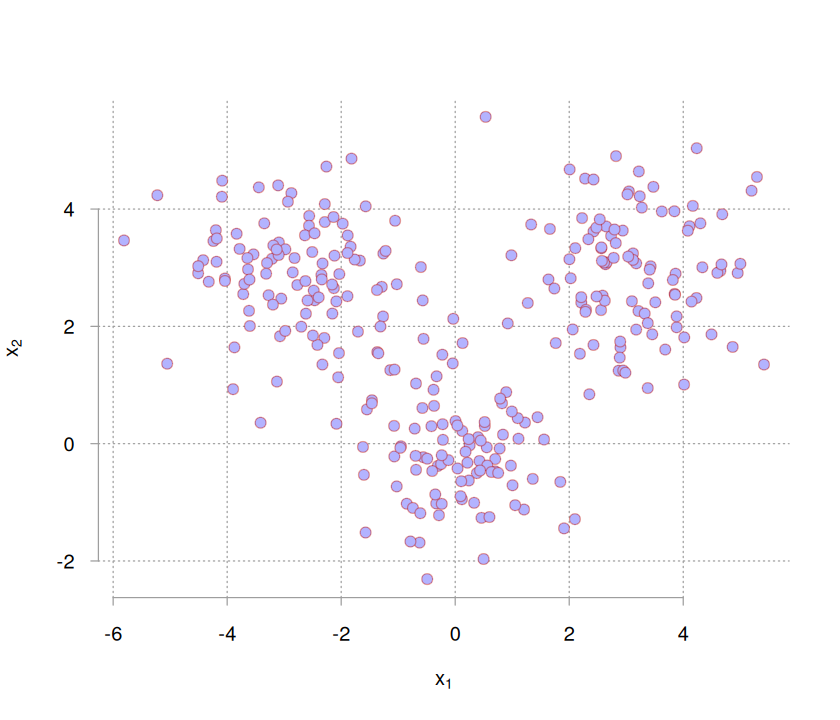

In [38]:
options(repr.plot.width = 7, repr.plot.height = 6)

scatter_plot(
  df$x1, df$x2,
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = red_light, fill = blue_light
)

df_xbiv <- data.frame(x1 = x[, 1], x2 = x[, 2])
write.csv(df_xbiv, "cluster_bivariado.csv", row.names = FALSE)


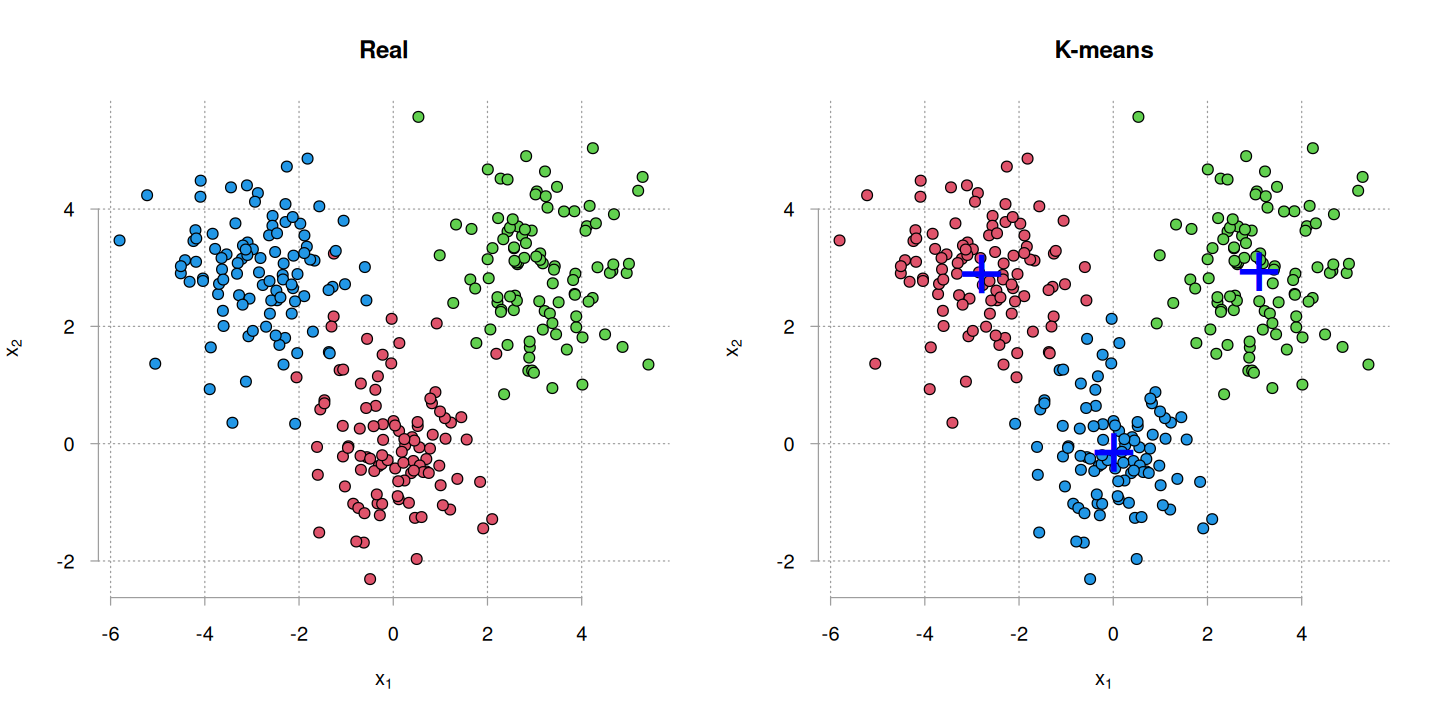

In [39]:
options(repr.plot.width = 12, repr.plot.height = 6)
km3 <- kmeans(x, 3, iter.max = 2000, nstart = 3)
df$cls <- km3$cluster

par(mfrow = c(1, 2))
scatter_plot(
  df$x1, df$x2,
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = 1, fill = df$y + 1,
  main = "Real"
)

scatter_plot(
  df$x1, df$x2,
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = 1, fill = df$cls + 1,
  main = "K-means"
)
points(km3$centers[, 1], km3$centers[, 2], pch = "+", cex = 4, col = 'blue')


In [40]:
# número de clústers
k <- 3
# obtener centroides a partir de los datos, pero puede ser cualquier centroide
centroids_k <- sample.int(dim(x)[1], k)
centroids <- x[centroids_k, ] |> as.matrix()
# prealojar espacio para matriz de distancias
dist_mat <- matrix(0, nrow = nrow(x), ncol = k)
# obtener las distancias
for (j in 1:k) {
  for (i in 1:nrow(x)) {
    dist_mat[i, j] <- sqrt(sum((x[i, ] - centroids[j, ])^2))
  }
}
# matriz de distancias
head(dist_mat)
# MARGIN es similar a axis en numpy; 1 es para las filas: la función entonces por
# fila selecciona la columna con la distancia mínima; retorna un vector del mismo
# tamaño que la matriz de datos, por lo que en este punto es equivalente
# a asignar la observación x_i al cluster k
cluster <- apply(X = dist_mat, MARGIN = 1, FUN = which.min)
cluster

0.8382737,1.1842585,6.178024
2.2006933,1.6334960,4.312767
1.3123193,2.7309904,4.735589
2.1405761,0.2871484,6.032991
1.0595102,1.1640970,6.400697
1.8164588,1.6332157,4.376201


[1] 1 2 1 2 1 2 1 1 2 2 1 2 2 2 1 2 1 1 2 2 1 1 2 2 2 2 1 1 1 1 2 2 1 2 1 2 2
 [38] 1 2 2 1 1 1 2 1 1 2 2 1 2 1 2 1 2 1 1 1 1 2 2 2 1 2 1 1 2 2 1 1 2 2 2 1 1
 [75] 2 1 2 2 2 2 2 1 1 2 1 1 1 2 1 2 1 2 1 2 2 2 2 1 2 2 3 3 3 3 3 3 3 3 3 1 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[297] 1 1 1 1

Calculamos ahora el resultado de la ecuación (3), que podríamos definir como la suma total de $W(C_k)$, o `total_WCSS` (total within-cluster sum of squares).

$$
  W_{\text{total}}(C_k) = \sum_{k=1}^K \sum_{x_i\in C_k}(x_{ij}-\bar x_k)^2\tag{4}
$$

In [41]:
# calcular eq 4
dist_mat_cluster <- list()
# para clusters de 1 a k
for (i in 1:k) {
  # retornar la suma de cuadrados en el cluster i minimizado;
  # elevamos al cuadrado nuevamente la distancia euclideana
  dist_mat_cluster[[i]] <- dist_mat[which(cluster == i), i]^2
}

# obtener la suma de cuadrados intra-cluster
within_cluster_ss <- unlist(lapply(dist_mat_cluster, sum))
# obtener la suma de cuadrados intracluster total
total_WCSS = sum(within_cluster_ss)
cat("\nTotal within-cluster sum of squares:", total_WCSS)



Total within-cluster sum of squares: 1761.809

Una vez que minimizamos las distancias y encontramos los clústers en la iteración 1, recalculamos los centroides. Los nuevos centroides serán el promedio $\bar x_k$ de cada clúster (y, recordar, estos nuevos clústers se encontraron minimizando $W(C_k)$, por lo que los nuevos centroides en el paso $t+1$ mejoraron la distancia intraclúster). 

In [42]:
new_centroid <- x %>%
  as.data.frame() %>%
  cbind(Clusters = cluster) %>%
  group_by(Clusters) %>%
  summarise_all(mean)
new_centroid_points <- new_centroid[, -1] %>% as.matrix()
# centroides después de primera iteración
new_centroid_points

V1,V2
-1.9892948,2.2038241
0.4004146,-0.6410541
3.1914786,2.9947752


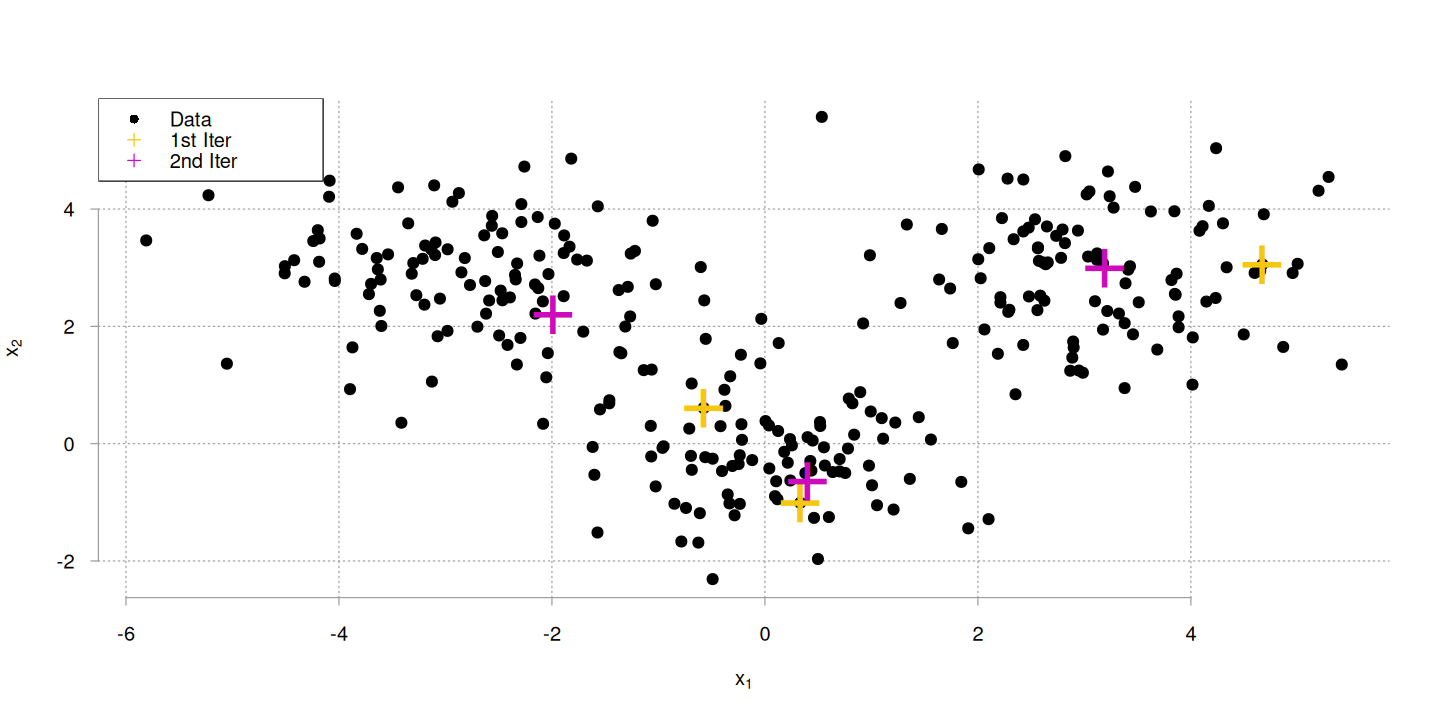

In [43]:
scatter_plot(
  df$x1, df$x2,
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = 1, fill = 1
)
points(centroids[, 1], centroids[, 2], pch = "+", cex = 4, col = 7)
# nuevos centroides
points(new_centroid_points[, 1], new_centroid_points[, 2], pch = "+", cex = 4, col = 6)
legend(
  "topleft",
  legend = c("Data", "1st Iter", "2nd Iter"),
  col = c(1, 7, 6),
  pch = list(16, 3, 3),
  pt.cex = 1
)

Juntando todo

In [44]:
k_means <- function(df, k, iters) {
  # iniciar centroides
  centroids_k <- sample.int(dim(df)[1], k)
  centroids <- df[centroids_k, ] %>% as.matrix()
  data_mat <- as.matrix(df)

  # iniciar within-cluster sum of squares
  within_cluster_ss <- c()
  total_WCSS <- c()
  for (i in 1:iters) {
    dist_mat <- matrix(0, nrow = nrow(data_mat), ncol = k)
    for (j in 1:k) { # para cada j en 1 hasta k
      for (i in 1:nrow(data_mat)) { # para cada i en i hasta n
        # suma de cuadrados x_i - x_media_k
        dist_mat[i, j] <- sqrt(
          sum((data_mat[i, ] - centroids[j, ])^2)
        )
      }
    }
    # obtener clusters con los índices que minimicen la distancia
    cluster <- apply(dist_mat, 1, which.min)
    dist_mat_cluster <- list()
    for (i in 1:k) {
      dist_mat_cluster[[i]] <- dist_mat[which(cluster == i), i]^2
    }

    within_cluster_ss_temp <- unlist(lapply(dist_mat_cluster, sum))
    within_cluster_ss <- append(within_cluster_ss, within_cluster_ss_temp)
    total_WCSS <- append(total_WCSS, sum(within_cluster_ss_temp))

    # recalcular centroides
    new_centroid <- df %>%
      as.data.frame() %>%
      cbind(Clusters = cluster) %>%
      group_by(Clusters) %>%
      summarise_all(mean)
    centroids <- new_centroid[, -1] %>% as.matrix()
  }
  within_cluster_ss <- t(array(within_cluster_ss, dim = c(k, iters)))
  # retornar
  list(
    Cluster = cluster,
    WCSS = within_cluster_ss,
    centroids = centroids,
    total_WCSS = total_WCSS
  )
}


In [45]:
kmeans_scratch <- k_means(x, 3, 250)
kmeans_scratch$centroids

V1,V2
-2.79160201,2.8959495
3.11826753,2.9425658
0.02291773,-0.1252795


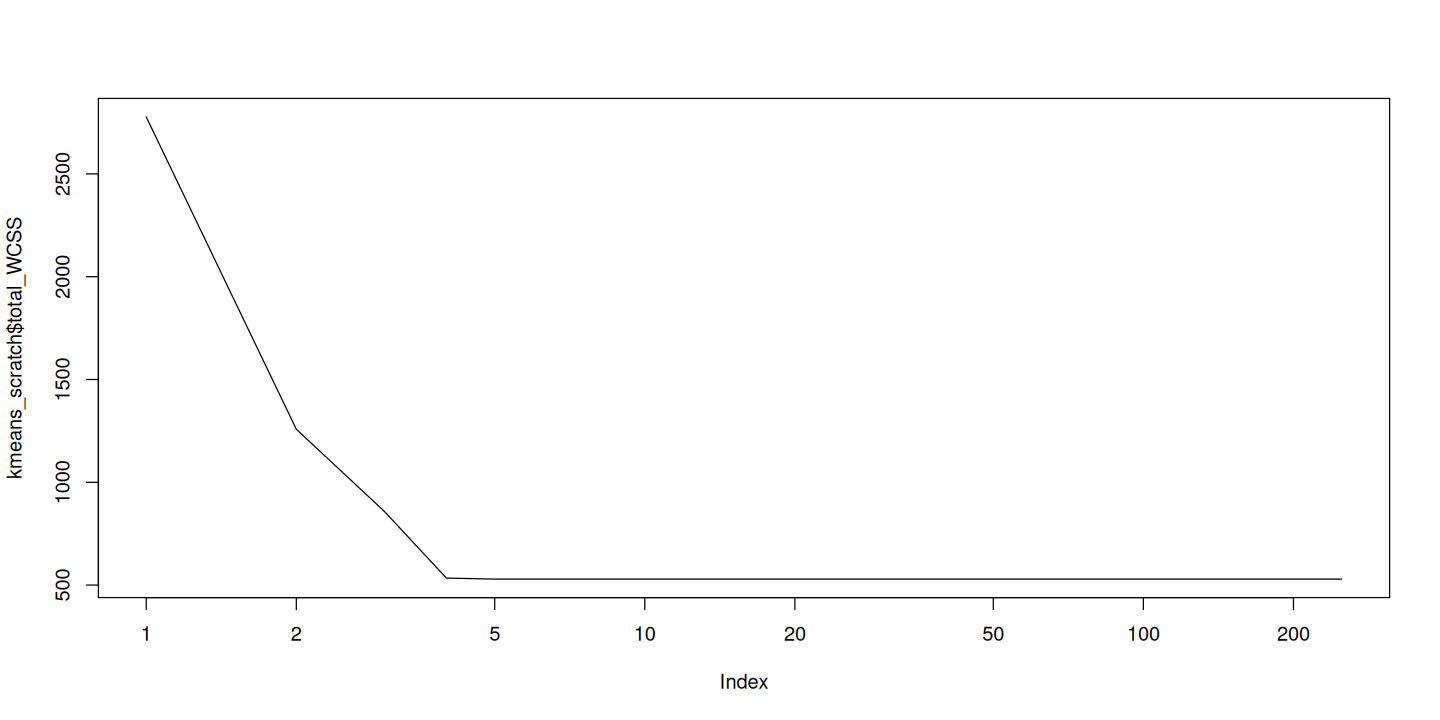

In [46]:
plot(kmeans_scratch$total_WCSS, type = 'l', log = 'x')

1,-2.79160201,2.895949
2,3.09673812,2.933816
3,0.01345089,-0.148178


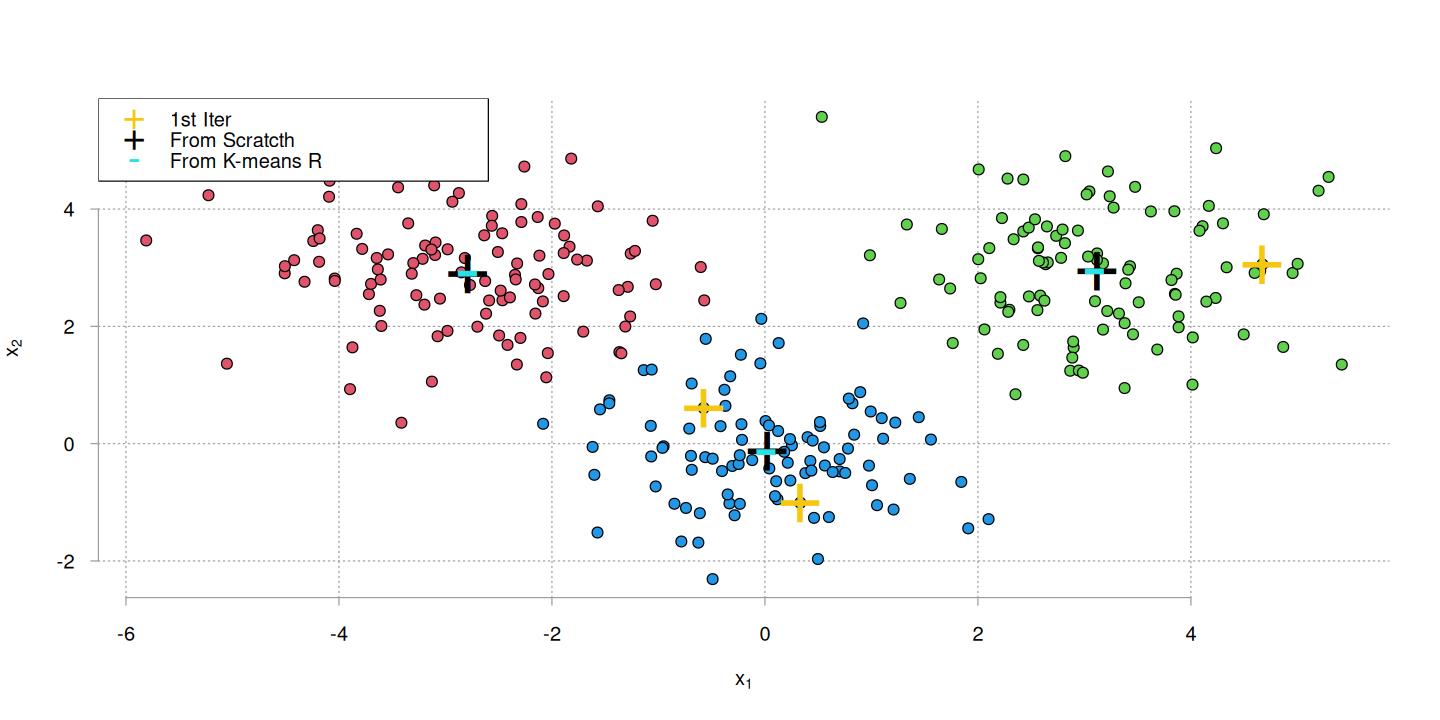

In [47]:
scatter_plot(
  df$x1, df$x2,
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = 1, fill = kmeans_scratch$Cluster + 1
)

points(centroids[, 1], centroids[, 2], pch = "+", cex = 4, col = 7)
# nuevos centroides
points(
  kmeans_scratch$centroids[, 1],
  kmeans_scratch$centroids[, 2],
  pch = "+", cex = 4, col =  1
)
# con función kmeans, color cyan
points(km3$centers[, 1], km3$centers[, 2], pch = "-", cex = 4, col = 5)
legend(
  "topleft",
  legend = c("1st Iter", "From Scratcth", "From K-means R"),
  col = c(7, 1, 5),
  pch = c("+", "+", "-"),
  pt.cex = 2
)
km3$centers

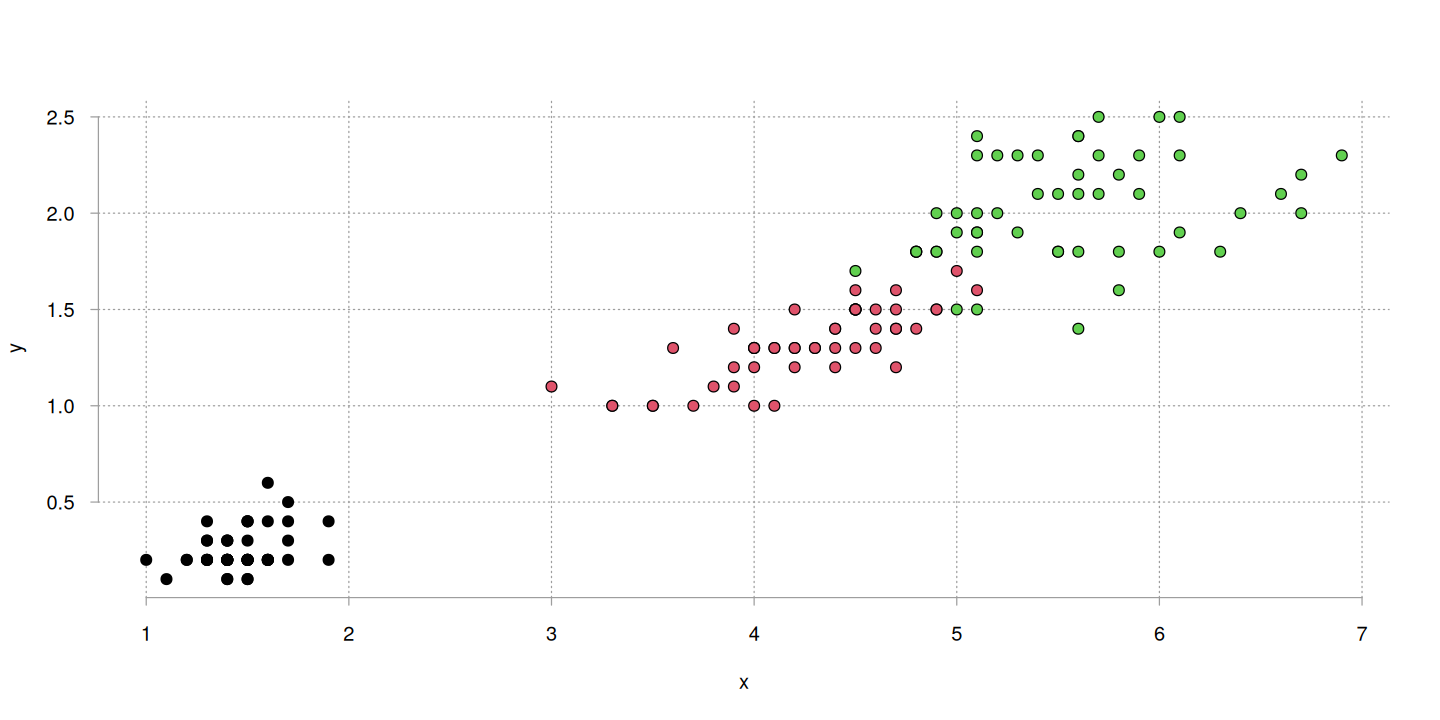

In [48]:
scatter_plot(iris[, 3], iris[, 4], color = 1, fill = iris$Species)

In [49]:
df_iris <- iris |>
  select(3:4)
iris_km_scratch <- k_means(df_iris, 3, 150)


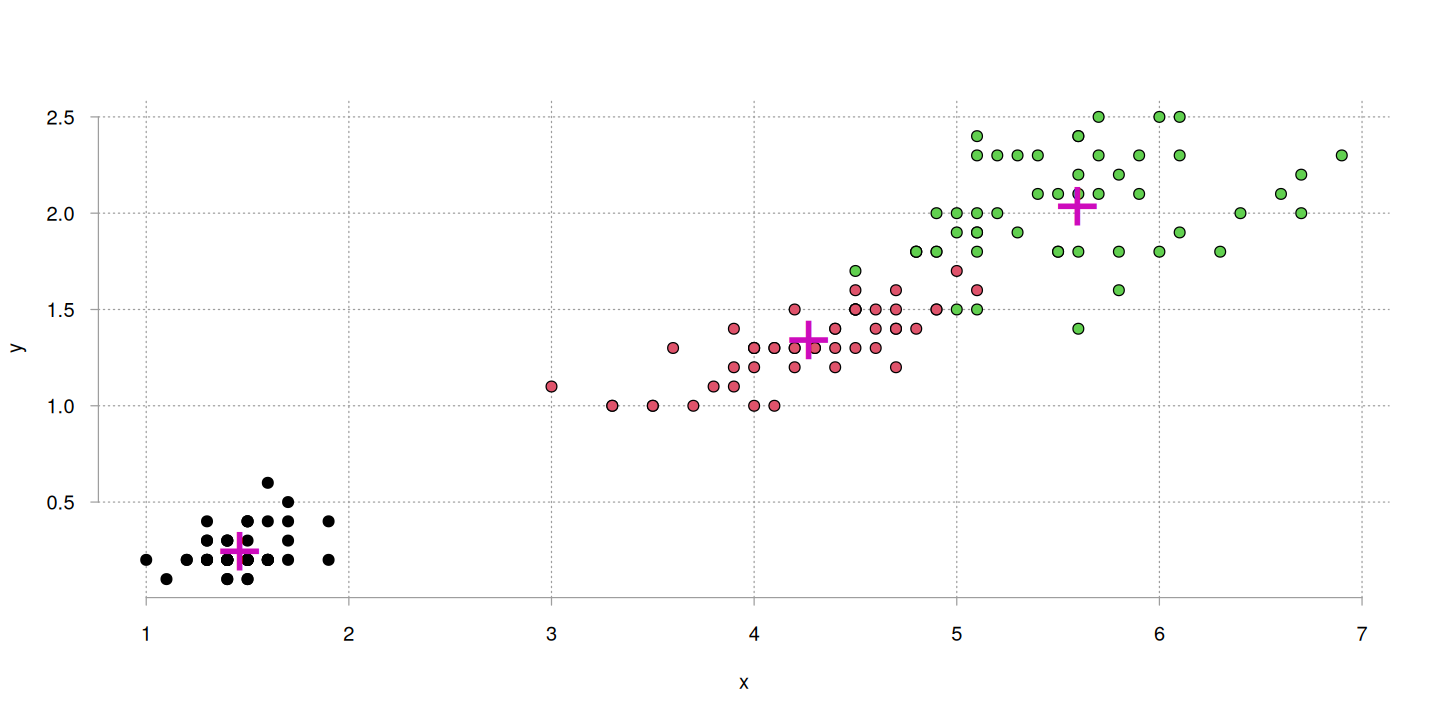

In [50]:
scatter_plot(iris[, 3], iris[, 4], color = 1, fill = iris$Species)
points(
  iris_km_scratch$centroids[, 1],
  iris_km_scratch$centroids[, 2],
  pch = "+", cex = 4, col = 6
)

¿Cómo decidir el número de clústers?

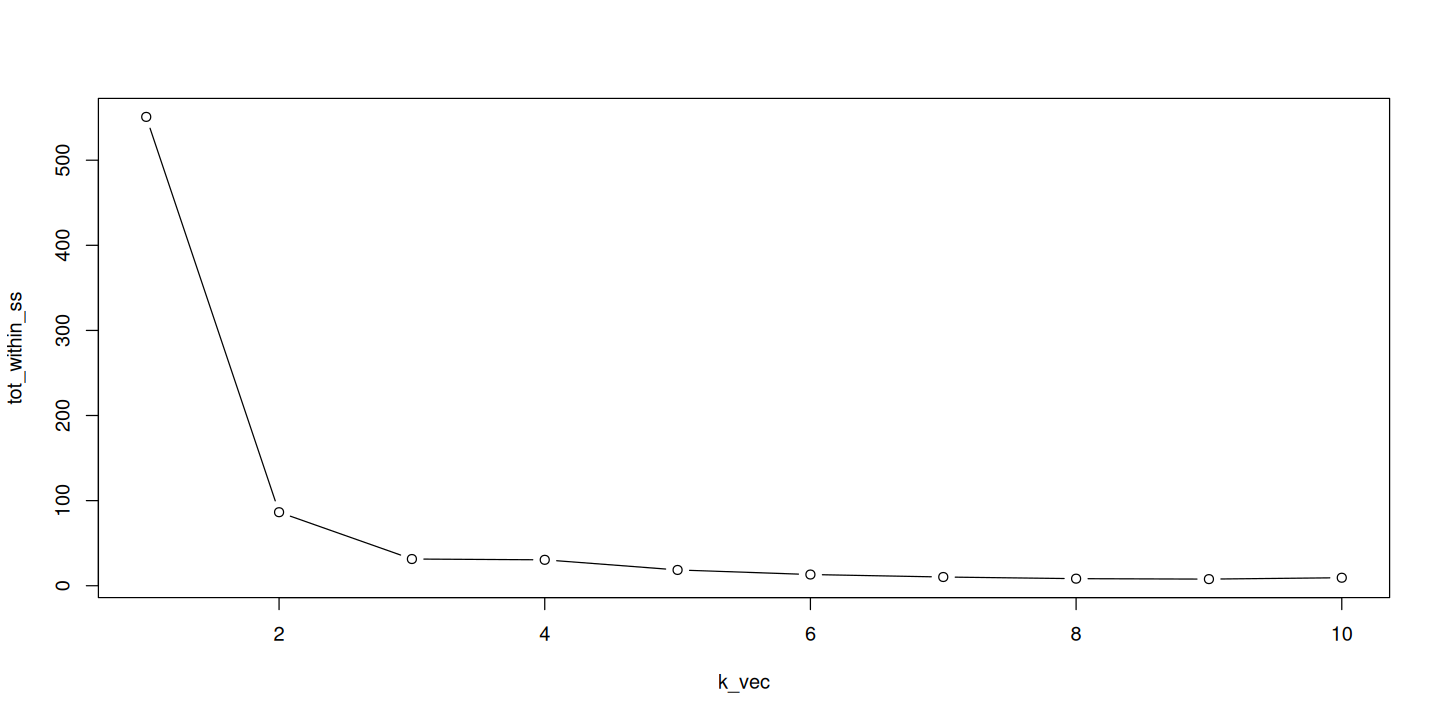

In [51]:
k_vec <- 1:10

tot_within_ss <- rep(NA, length(k_vec))

for (i in k_vec) {
  km_iris <- kmeans(df_iris, i, iter.max = 150)
  tot_within_ss[i] <- km_iris$tot.withinss
}

plot(k_vec, tot_within_ss, type = 'b')

**Número de clústers usando el estadístico Gap**

Repaso:

El análisis de clúster es una técnica no supervisada. El problema es encontrar grupos en los datos sin una variable de respuesta (sin una $y$ observada). Sin esa variable observada, encontrar el número óptimo de clústers es un desafío.

El estadístico $W(C_k)$, la medida de error, decrece monotónicamente, como se puede ver en la imagen anterior, con respecto al número de clústers $k$. En ocasiones, la medida de error decrece rápidamente y existe un punto, llamado *elbow* (codo) en donde decrece lentamente. Es común elegir este punto como el número óptimo de clústers. El estadístico Gap formaliza esta intuición.

El estadístico Gap compara la variación total intra-clúster para diferentes valores de $k$ con respecto a la variación esperada si no hubiese clústers (una distribución nula, por ejemplo una distribución uniforme, en donde cabría esperar un único componente).

$$
  \text{Gap}_n(k) = \text{E}^*_n[\log(W_k)] - \log(W_k)
$$

En donde $\text{E}^*_n$ denota el valor esperado bajo una muestra de tamaño $n$ de la distribución de referencia. Nuestro $\hat k$ óptimo será aquel que maximice $ \text{Gap}_n(k)$

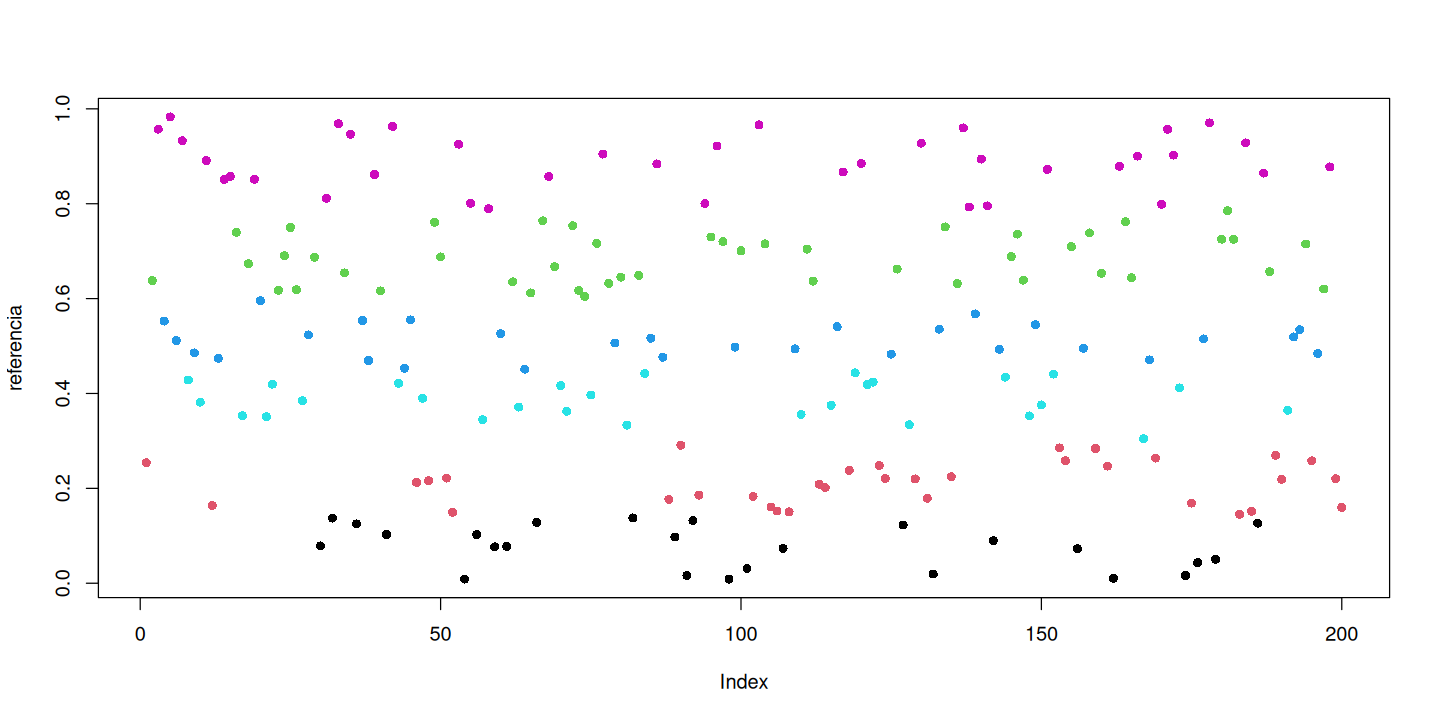

In [52]:
set.seed(14)
referencia <- runif(n = 200, 0, 1)

km_ref <- kmeans(referencia, 6, nstart = 25)
plot(referencia,col = km_ref$cluster, pch = 16)

Siguiendo la lógica del gráfico de $W_k$ como función de $k$, variamos de 1 a 15 para ver cómo se comporta.

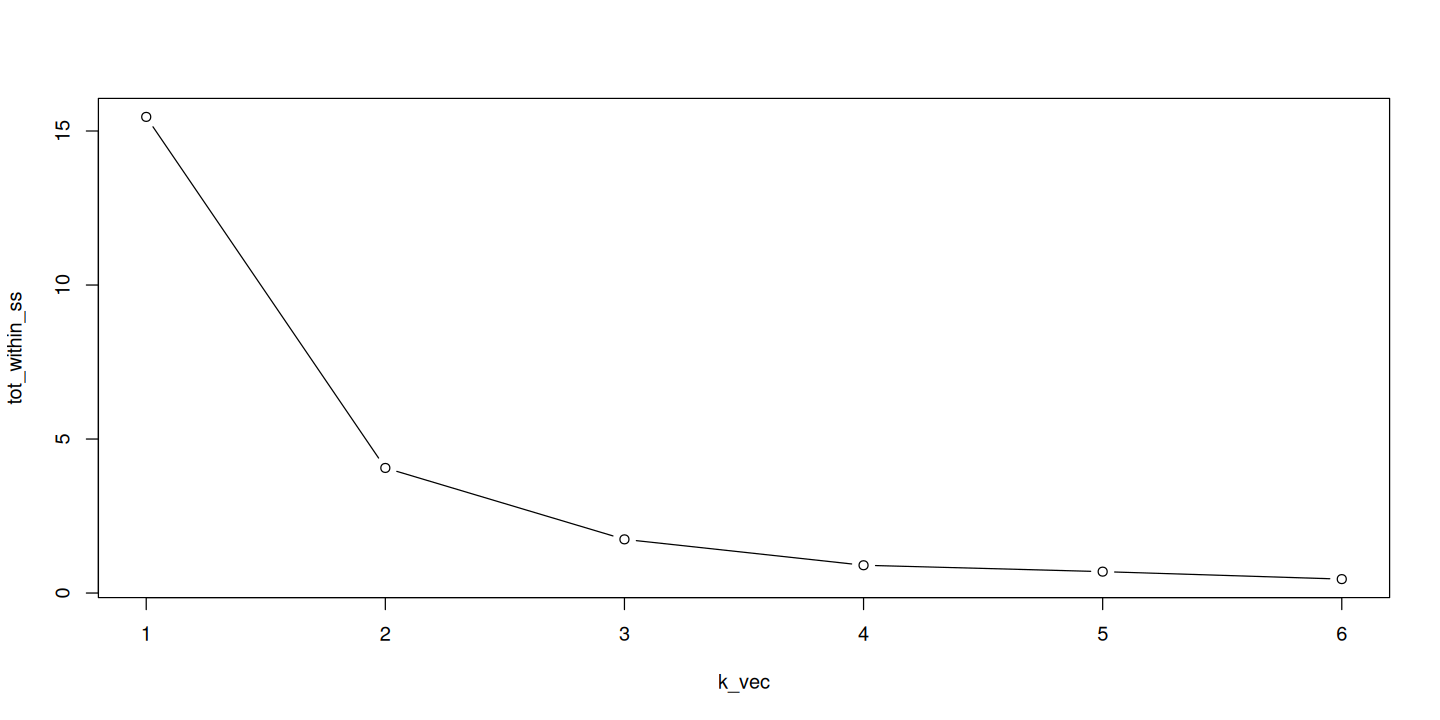

In [53]:
k_vec <- 1:6

tot_within_ss <- rep(NA, length(k_vec))

for (i in k_vec) {
  km_iris <- kmeans(referencia, i, iter.max = 150)
  tot_within_ss[i] <- km_iris$tot.withinss
}

plot(k_vec, tot_within_ss, type = 'b')

Pareciera que el número óptimo está entre 3 y 4. Pero ¿es razonable?

In [54]:
library(cluster)
df_ref <- data.frame(rows = 1:length(referencia), referencia = referencia)
gap_stat <- clusGap(df_ref, FUN = kmeans, nstart = 25, K.max = 15, B = 100, method = "globalmax")
# otros métodos disponibles son
# firstmax: da el k del primer máximo local encontrado
# Tibs2001SEmax: usa el criterio de Tibshirani et al 2001. Encuentra el k menor
#                tal que Gap(k) >= Gap(k+1) - SE(k+1), tal que considera el error
#                (efectivamente el k escogido es mayor que el límite inferior de Gap(k+1))

ERROR: Error in FUNcluster(X, kk, ...): unused argument (method = "globalmax")


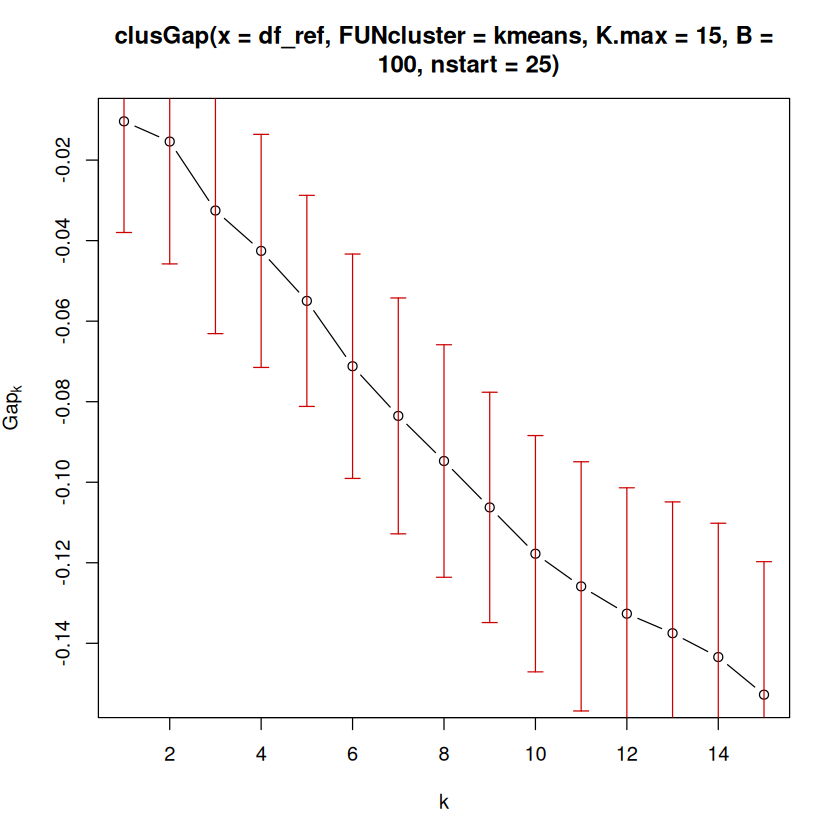

In [ ]:
plot(gap_stat)

In [ ]:
library(tidyverse)
df_iris <- iris |>
  select(3:4)

gap_iris <- clusGap(df_iris, FUN = kmeans, nstart = 25, K.max = 10, B = 200)

[1] "clusGap"

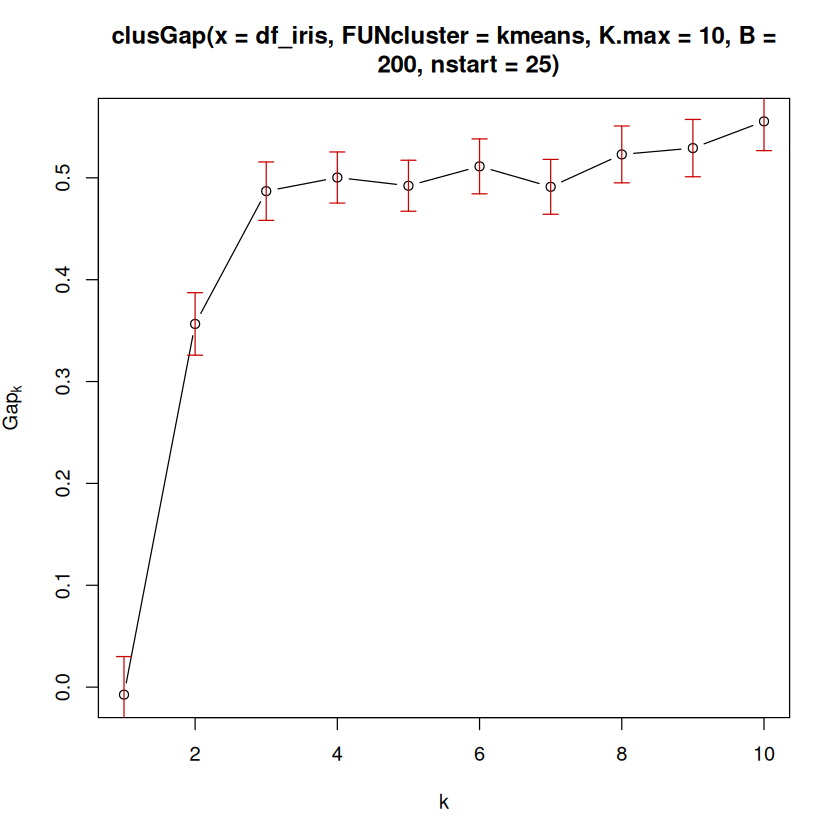

In [ ]:
class(gap_iris)

plot(gap_iris)

In [ ]:
print(gap_iris, method="Tibs2001SEmax")

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = df_iris, FUNcluster = kmeans, K.max = 10, B = 200, nstart = 25)
B=200 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'Tibs2001SEmax', SE.factor=1): 3
          logW   E.logW          gap     SE.sim
 [1,] 4.399580 4.392177 -0.007403292 0.03738783
 [2,] 3.410001 3.766557  0.356555971 0.03066725
 [3,] 2.949827 3.436735  0.486907376 0.02867302
 [4,] 2.730474 3.230759  0.500285162 0.02507507
 [5,] 2.598849 3.091065  0.492216194 0.02502116
 [6,] 2.476060 2.987303  0.511242889 0.02695796
 [7,] 2.413556 2.904713  0.491157249 0.02691682
 [8,] 2.308265 2.831235  0.522969994 0.02790136
 [9,] 2.234325 2.763507  0.529182274 0.02814243
[10,] 2.143673 2.699124  0.555451099 0.02877833


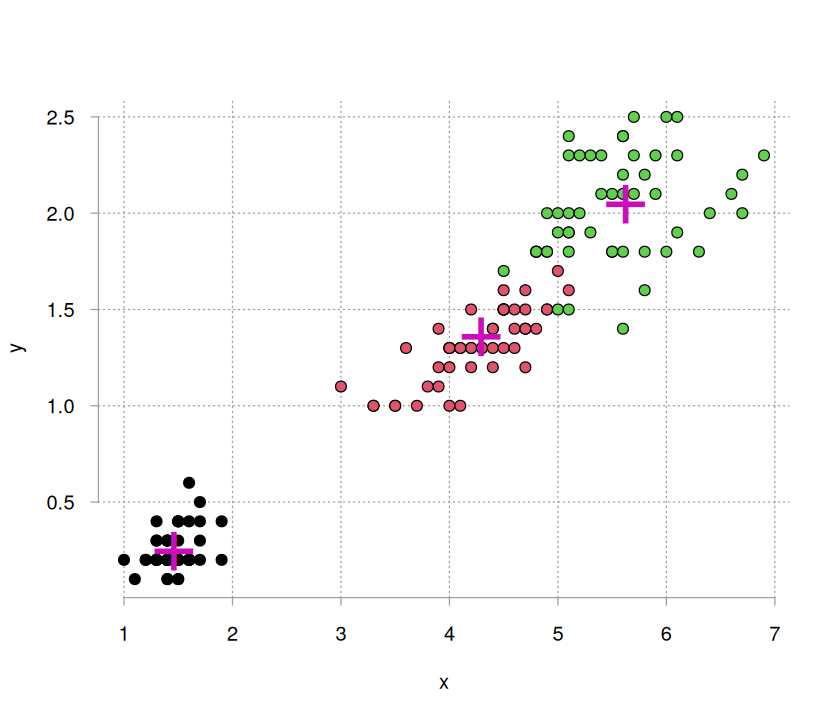

In [ ]:
scatter_plot(iris[, 3], iris[, 4], color = 1, fill = iris$Species)
points(
  iris_km_scratch$centroids[, 1],
  iris_km_scratch$centroids[, 2],
  pch = "+", cex = 4, col = 6
)

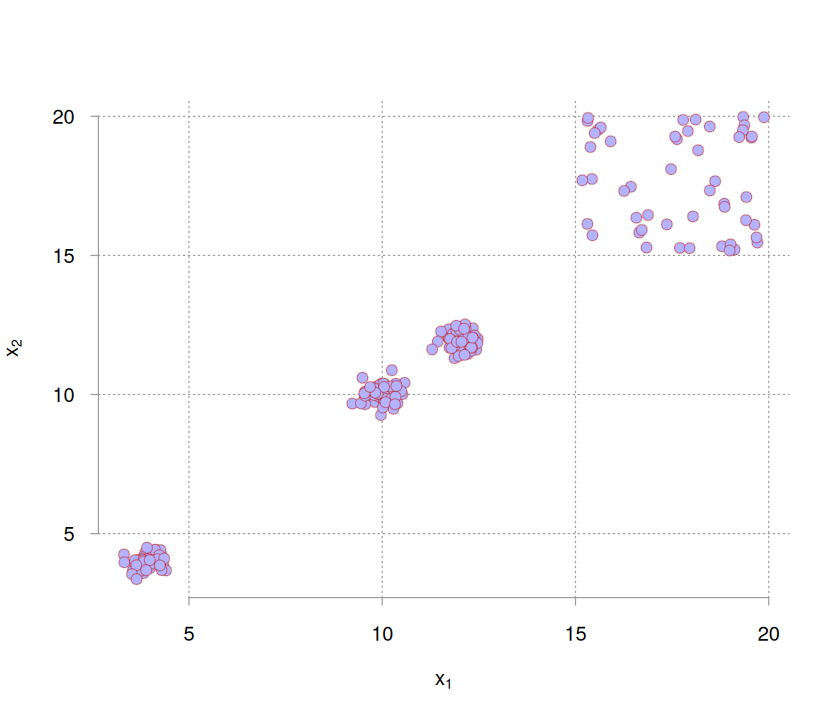

In [ ]:
x <- rbind(
  matrix(rnorm(100, mean = 4, sd = 0.3), ncol = 2),
  matrix(rnorm(100, mean = 12, sd = 0.3), ncol = 2),
  matrix(rnorm(100, mean = 10, sd = 0.3), ncol = 2),
  matrix(runif(100, 15, 20), ncol = 2)
)

scatter_plot(
  x[, 1], x[, 2],
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = red_light, fill = blue_light
)

In [ ]:
gap_x <- clusGap(x, FUN = pam, metric = 'manhattan',  nstart = 25, K.max = 10, B = 10)

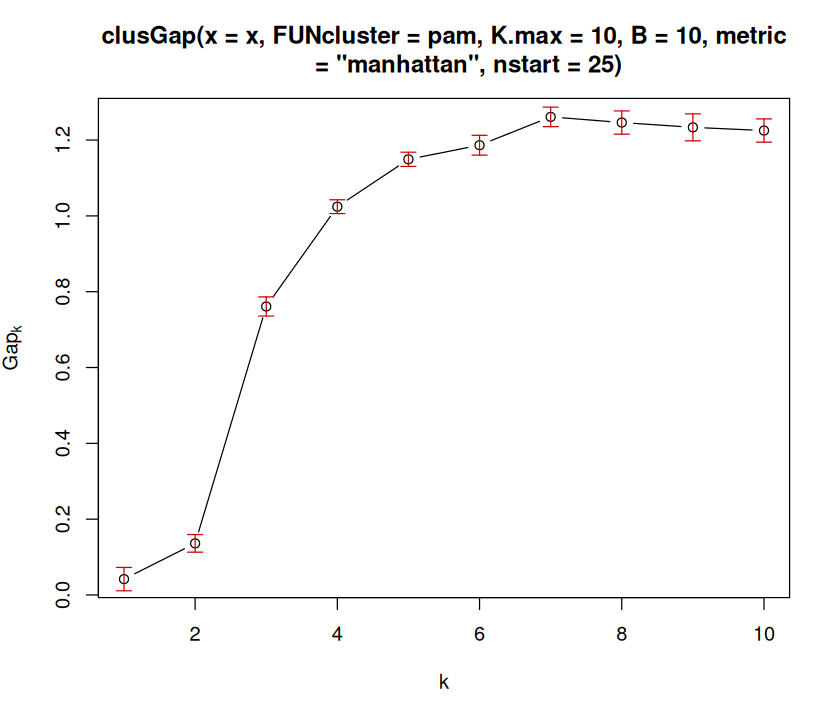

In [ ]:
plot(gap_x)

In [ ]:
print(gap_x, method = 'Tibs2001SEmax')

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = x, FUNcluster = pam, K.max = 10, B = 10, metric = "manhattan", nstart = 25)
B=10 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'Tibs2001SEmax', SE.factor=1): 7
          logW   E.logW        gap     SE.sim
 [1,] 5.985869 6.027678 0.04180957 0.03081980
 [2,] 5.328096 5.464201 0.13610441 0.02322687
 [3,] 4.432942 5.193940 0.76099857 0.02528755
 [4,] 4.009860 5.034184 1.02432351 0.01824827
 [5,] 3.786113 4.935393 1.14928064 0.01871117
 [6,] 3.660752 4.847254 1.18650203 0.02616058
 [7,] 3.505695 4.766862 1.26116693 0.02576164
 [8,] 3.436719 4.682975 1.24625555 0.03063070
 [9,] 3.370360 4.603945 1.23358502 0.03557637
[10,] 3.316769 4.541918 1.22514918 0.03069241


In [ ]:
kmeanxx <- kmeans(x, 7, 100, 25)
scatter_plot(
  x[, 1], x[, 2],
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = red_light, fill = kmeanxx$cluster
)

ERROR: Error in eval(expr, envir, enclos): object 'x' not found
